<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/Visualizing%20Word2Vec%20Word%20Embeddings%20using%20t-SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Word2Vec Word Embeddings using t-SNE
## 1. Visualizaing Similar Words from Google News

In [ ]:

##Be patient...this will take some time to download!
import gensim.downloader as api
model = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
keys = ['Paris', 'Python', 'Sunday', 'Tolstoy', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'financial', 'food', 'iOS', 'peace', 'release', 'war']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

<ipython-input-7-b04aadfc13d1>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


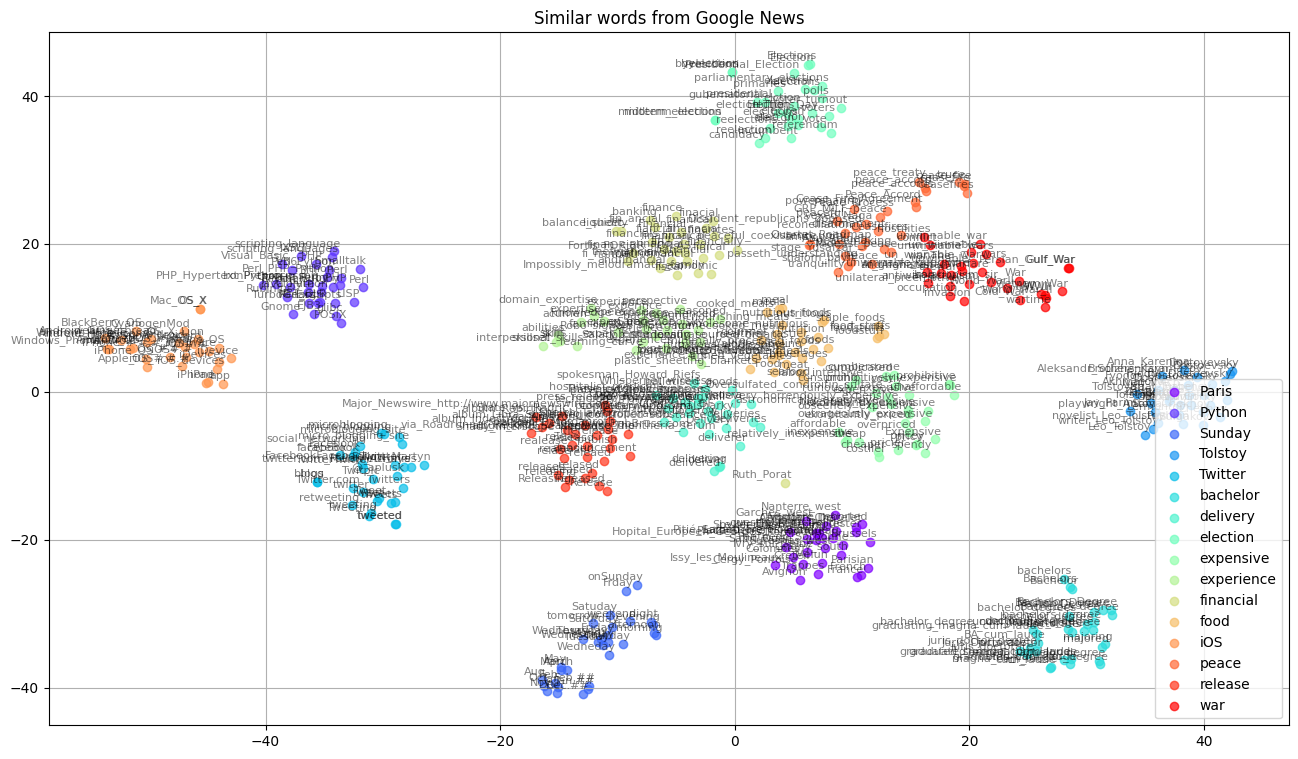

In [ ]:
import matplotlib.pyplot as plt
# import matplotlib.cm as cm matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

## 2. Visualizaing Word2Vec Vectors from Leo Tolstoy Books
To start with, it's necessary to download pretrained Punkt Sentence Tokenizer, which divides a text into a list of sentences considering abbreviation words, collocations, and words, which are probably indicates start or end of sentences. By default, NLTK data package doesnt include a pre-trained Punkt tokenizer for Russian, so we will third-party models from https://github.com/mhq/train_punkt.

In [1]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
my_path="/content/drive/MyDrive/CS491/Data/"

In [9]:
# !pip install multiprocessing -q

In [ ]:
import re
import codecs
import multiprocessing
import gensim
import mulitprocessing
from gensim.models import Word2Vec


def preprocess_text(text):
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


def prepare_for_w2v(filename_from, filename_to, lang):
    raw_text = codecs.open(filename_from, "r", encoding='windows-1251').read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(raw_text, lang):
            print(preprocess_text(sentence.lower()), file=f)


def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())

### 2.1. Visualizing Word2Vec Vectors from Anna Karenina

In [6]:
prepare_for_w2v(my_path+'Anna Karenina by Leo Tolstoy (ru).txt', 'train_anna_karenina_ru.txt', 'russian')
model_ak = train_word2vec('train_anna_karenina_ru.txt')

 return Word2Vec(data, vector_size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())


TypeError: Word2Vec.__init__() got an unexpected keyword argument 'size'

In [ ]:
words_ak = []
embeddings_ak = []
for word in list(model_ak.wv.vocab):
    embeddings_ak.append(model_ak.wv[word])
    words_ak.append(word)

tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

In [ ]:
def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('Anna Karenina by Leo Tolstoy', embeddings_ak_2d, a=0.1)

In [ ]:
tsne_plot_2d('Anna Karenina by Leo Tolstoy', embeddings_ak_2d, words_ak, 0.1)

### 2.2. War and Peace

In [ ]:
prepare_for_w2v('data/War and Peace by Leo Tolstoy (ru).txt', 'train_war_and_peace_ru.txt', 'russian')
model_wp = train_word2vec('train_war_and_peace_ru.txt')

In [ ]:
words_wp = []
embeddings_wp = []
for word in list(model_wp.wv.vocab):
    embeddings_wp.append(model_wp.wv[word])
    words_wp.append(word)

tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'War and Peace', embeddings_wp_3d, a=0.1)

## GIFs

In [ ]:
keys_gif = ['Paris', 'Python', 'Sunday', 'Tolstoy', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'financial', 'food', 'iOS', 'peace', 'release', 'war']

embedding_clusters_gif = []
word_clusters_gif = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model_gn.most_similar(word, topn=200):
        words.append(similar_word)
        embeddings.append(model_gn[similar_word])
    embedding_clusters_gif.append(embeddings)
    word_clusters_gif.append(words)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters_gif = np.array(embedding_clusters_gif)
n, m, k = embedding_clusters_gif.shape

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


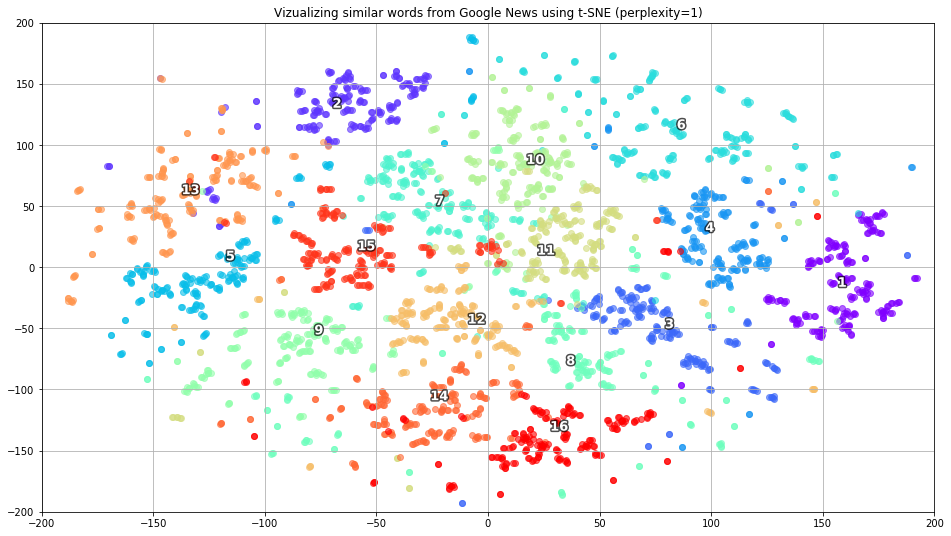

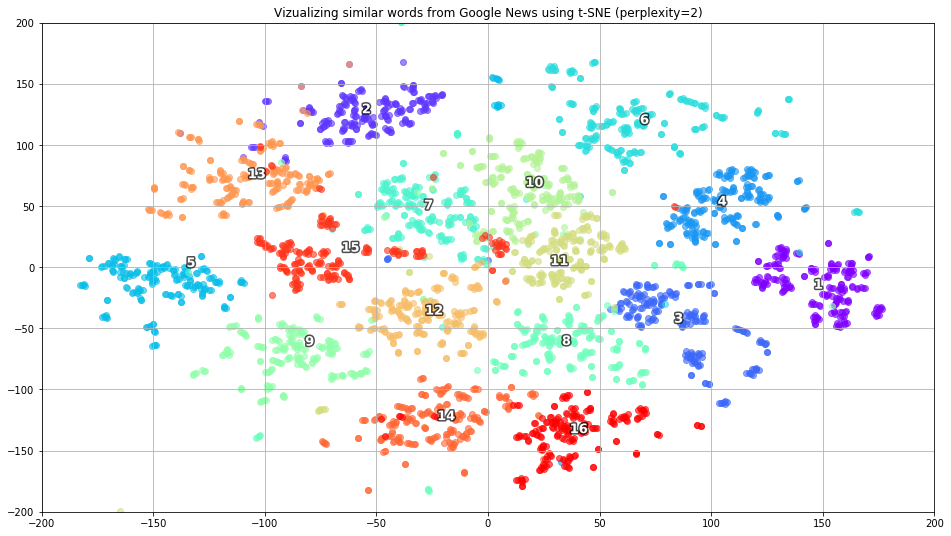

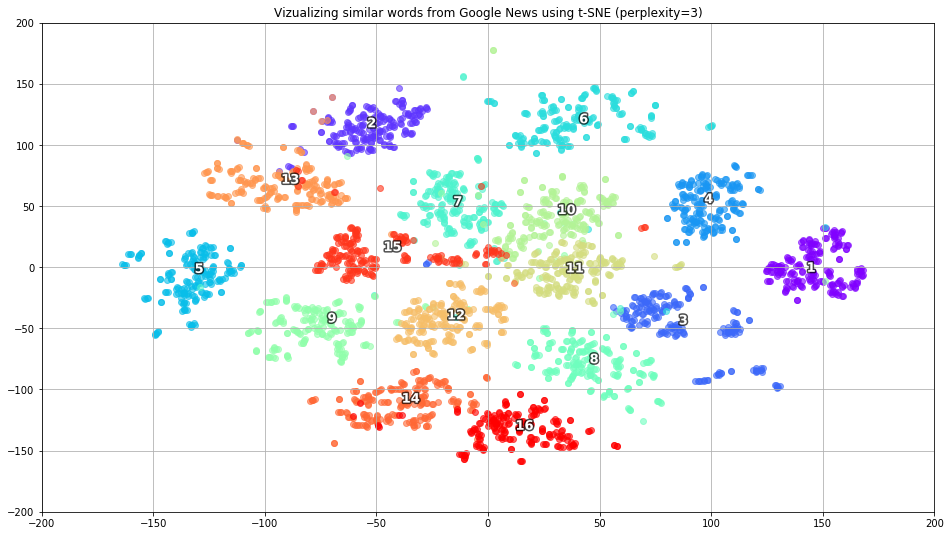

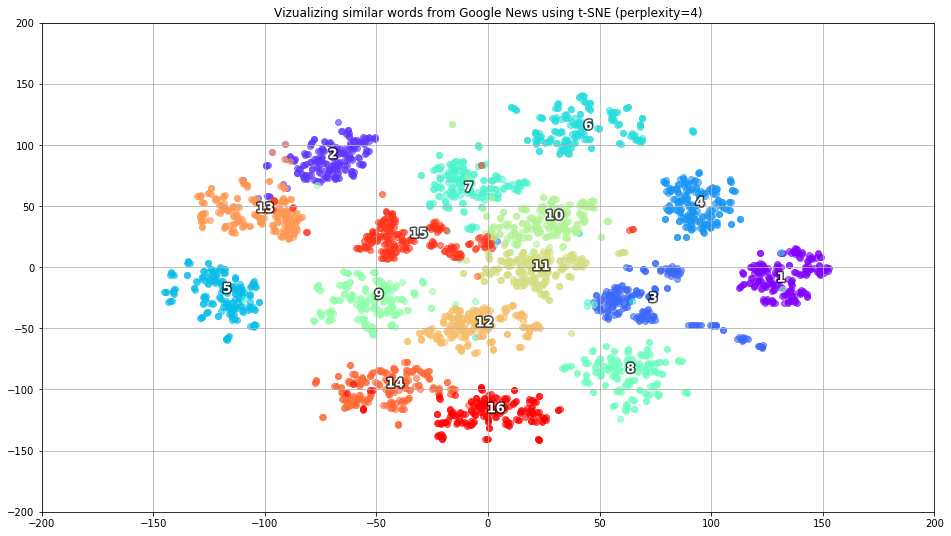

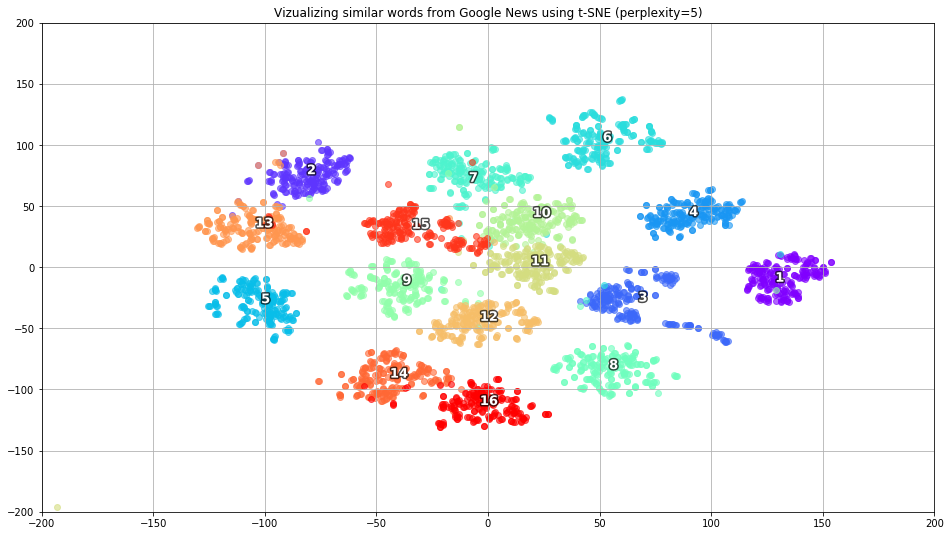

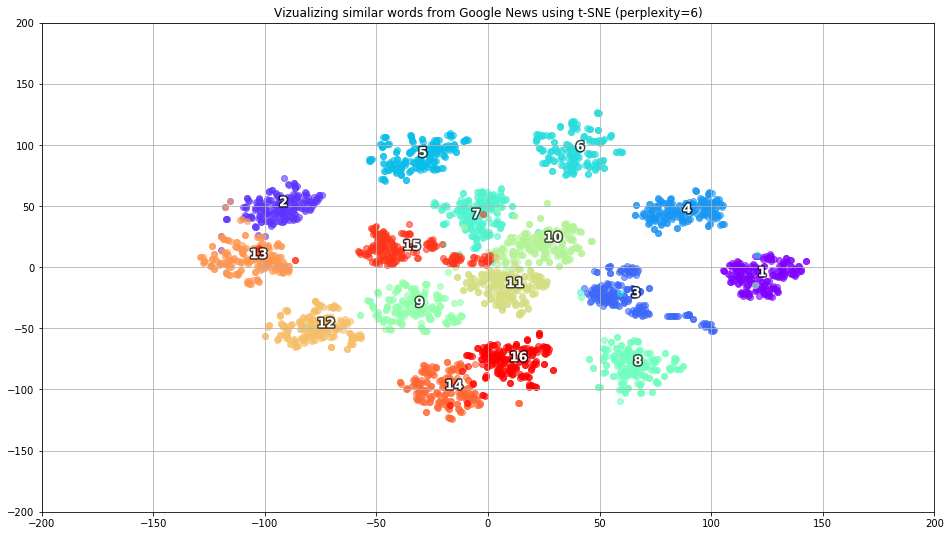

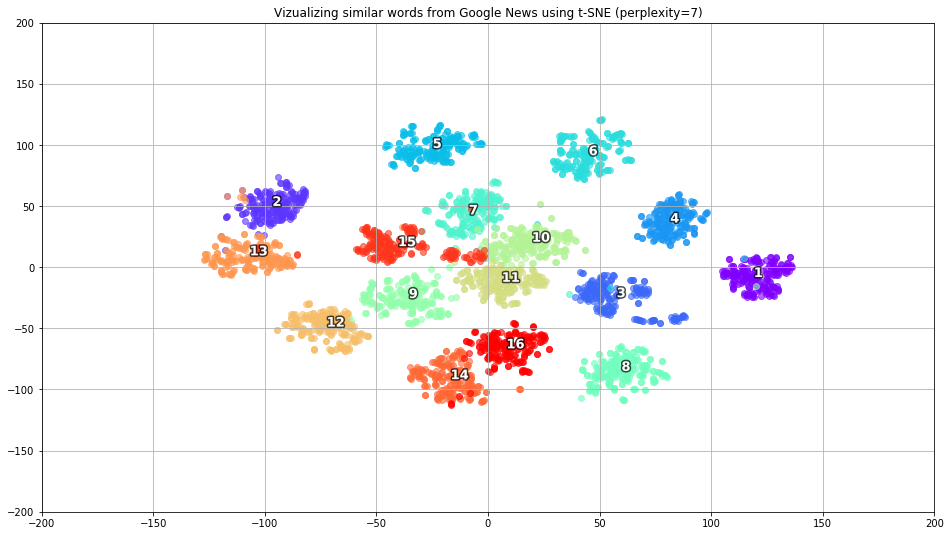

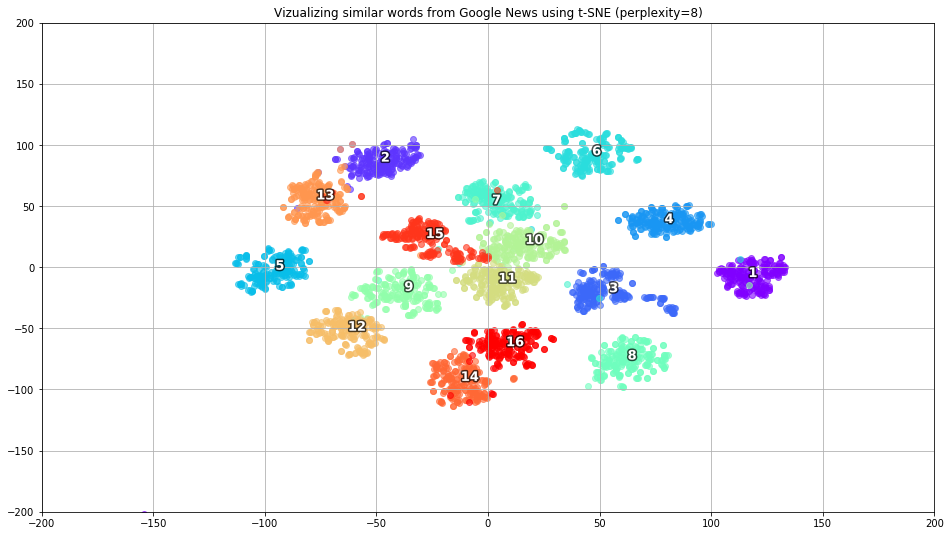

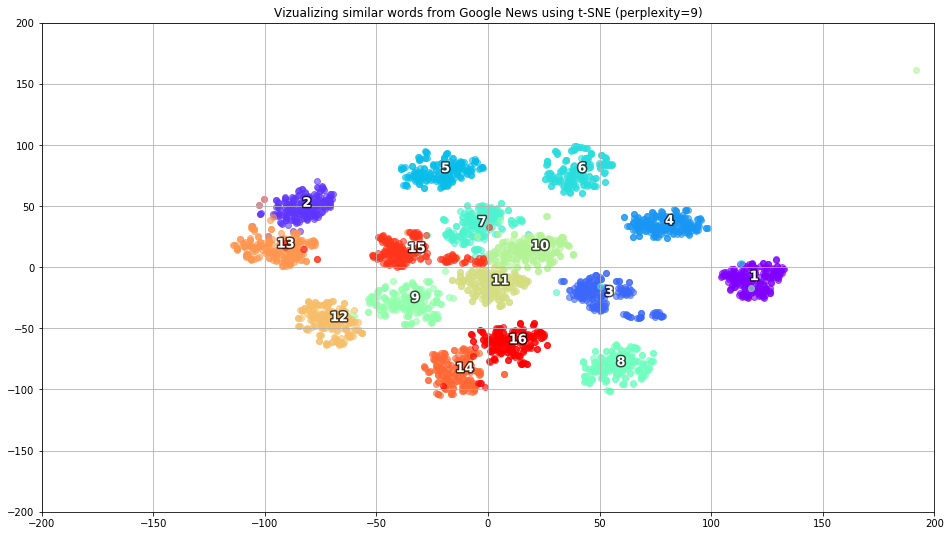

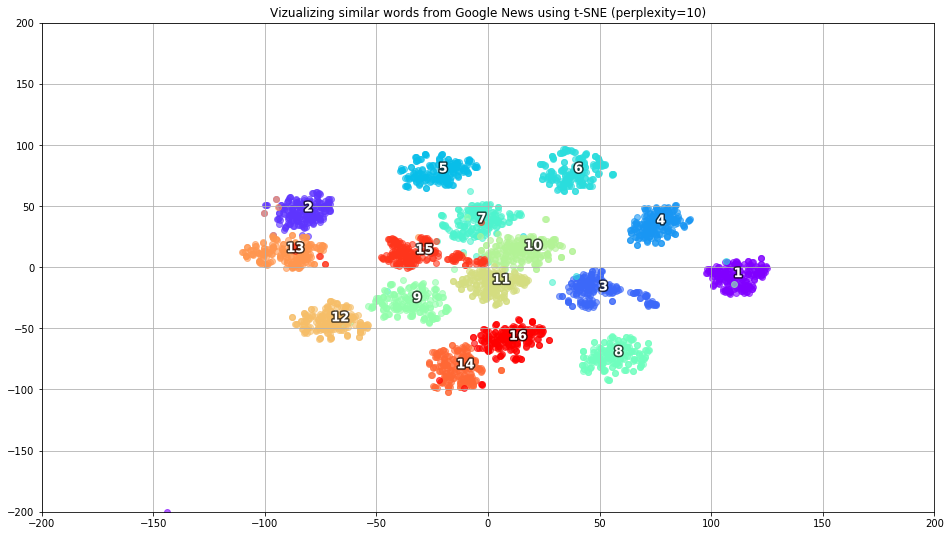

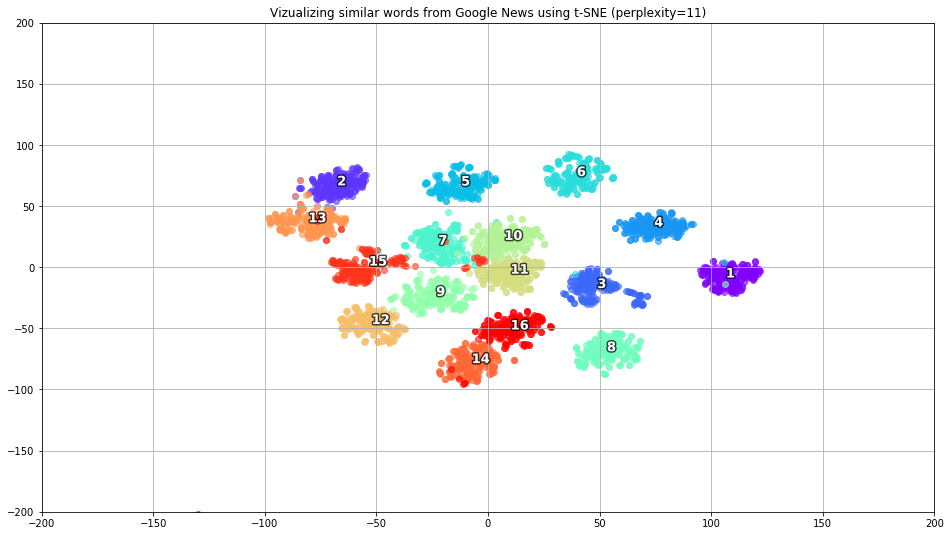

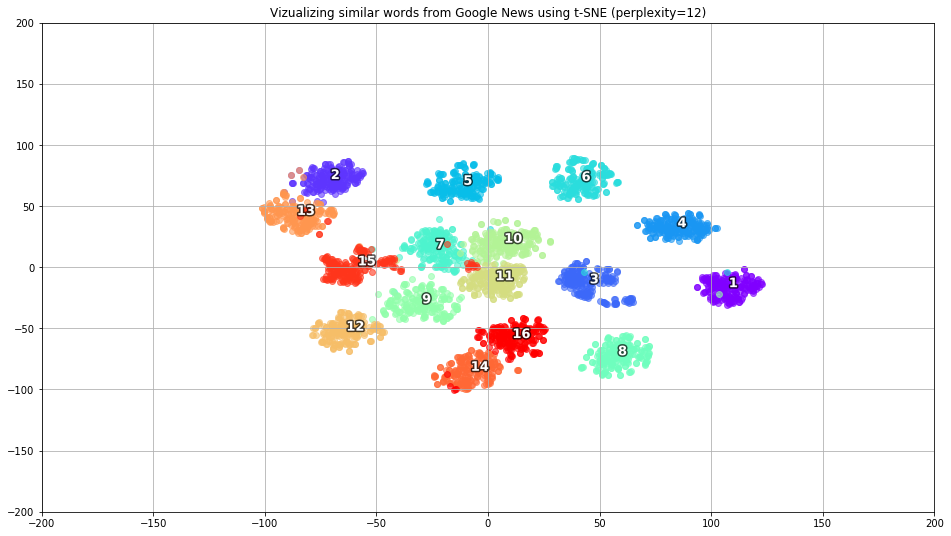

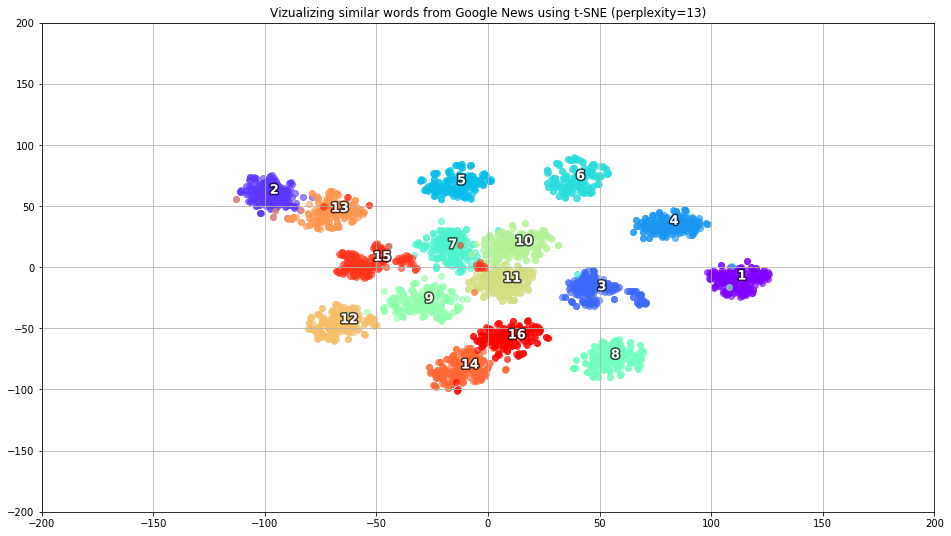

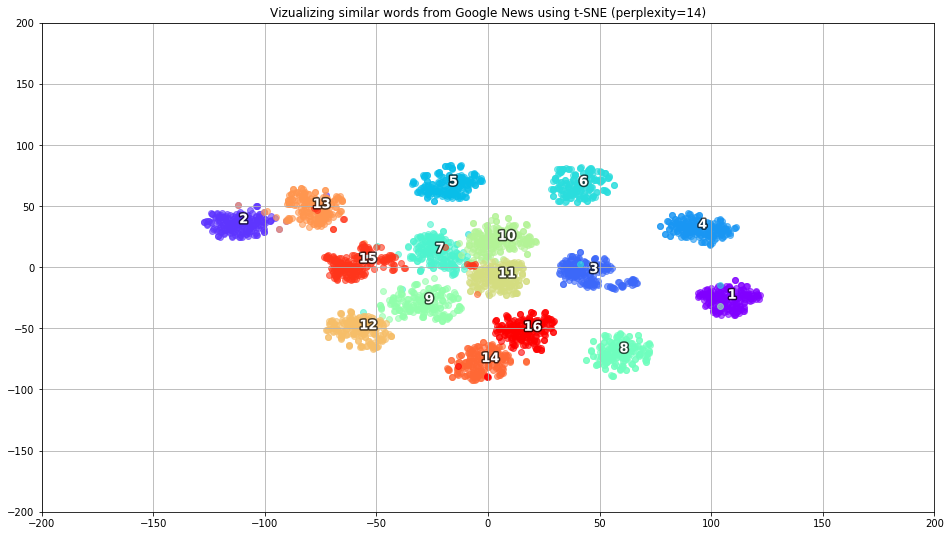

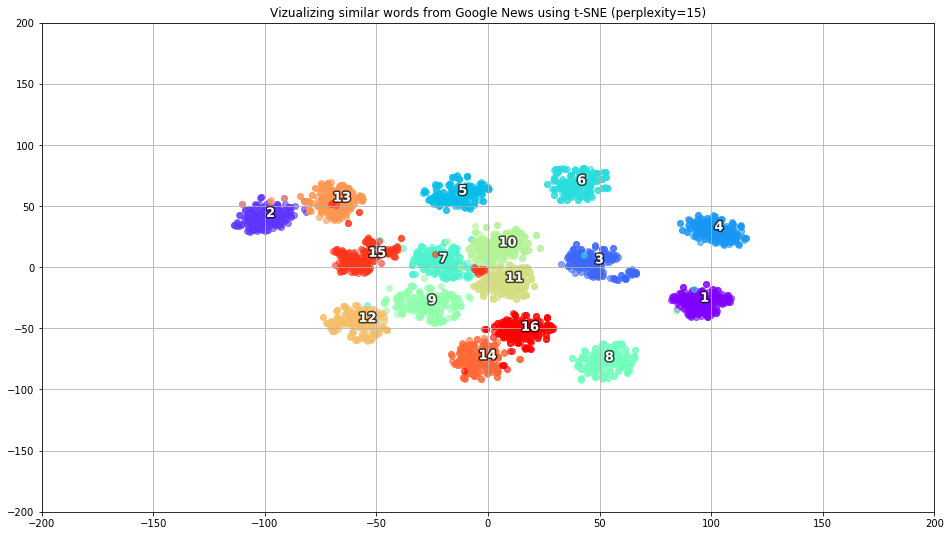

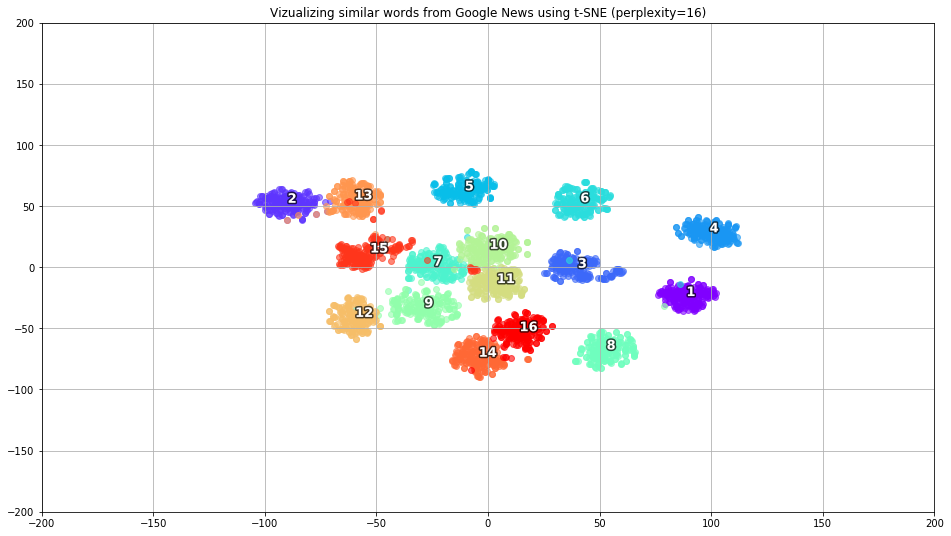

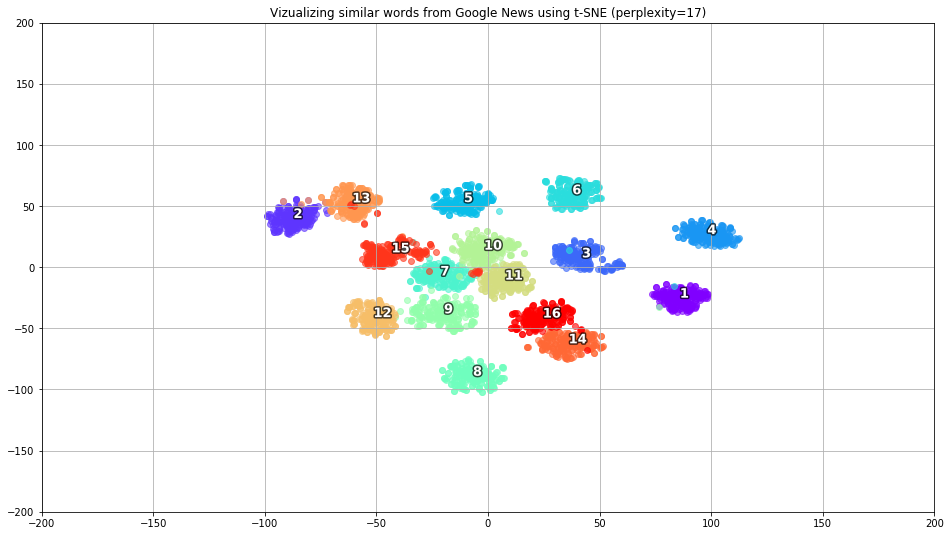

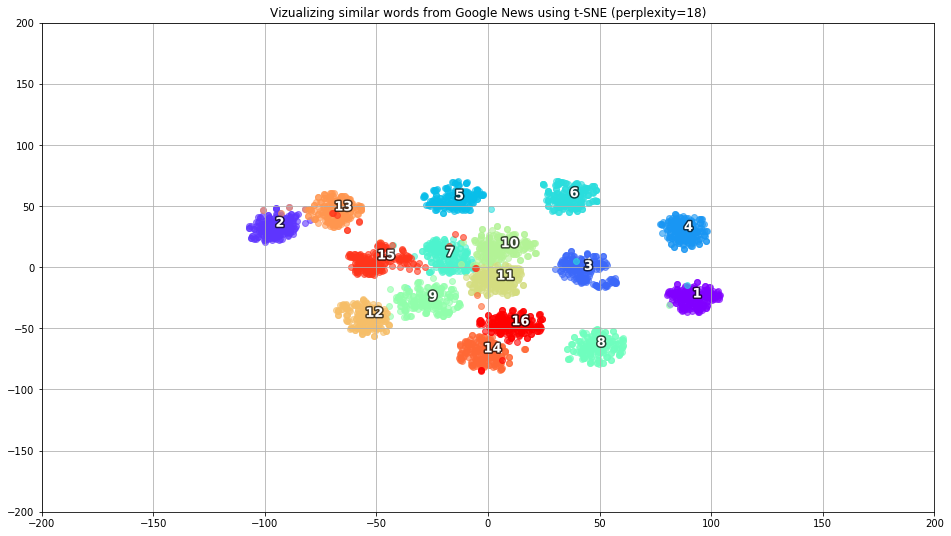

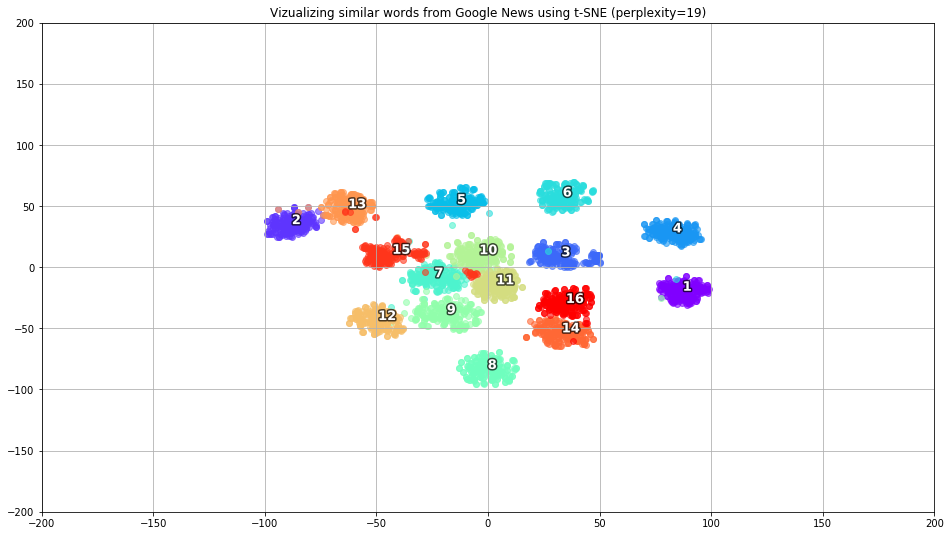

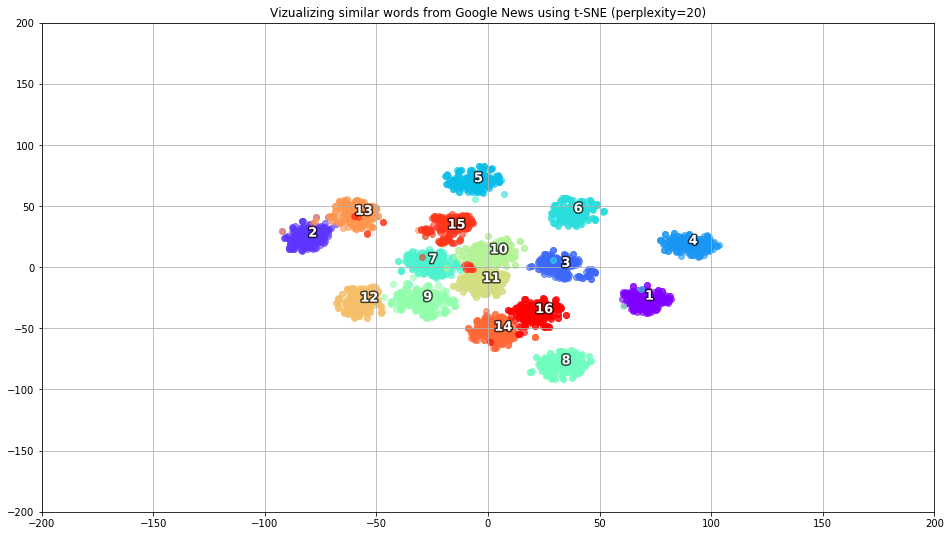

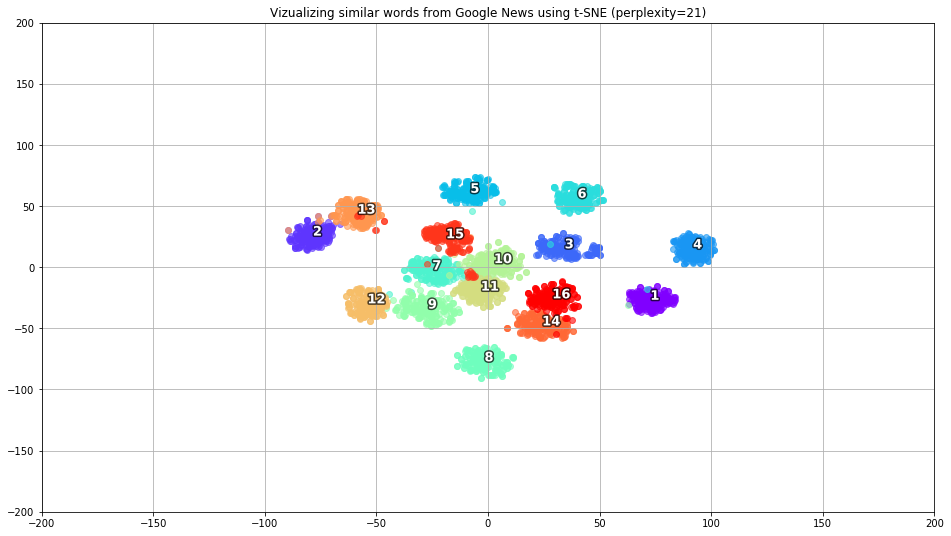

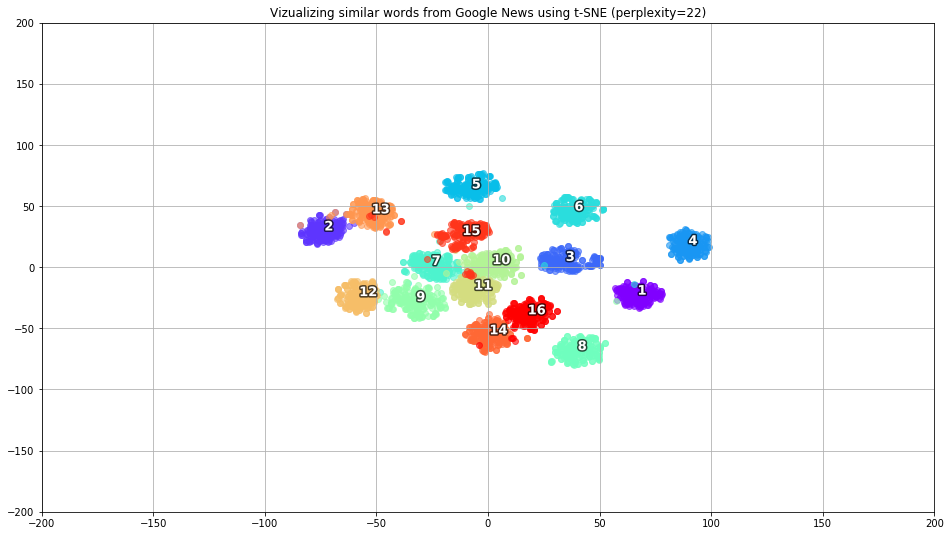

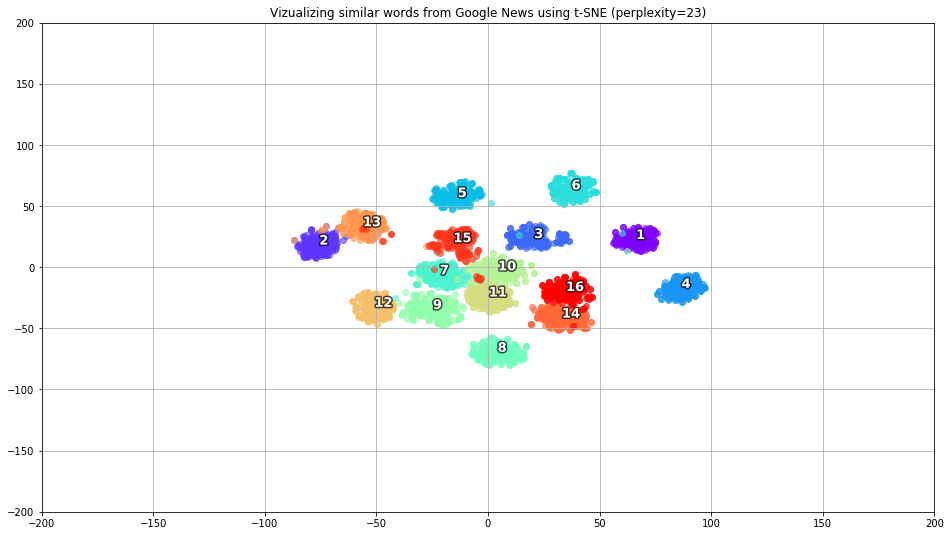

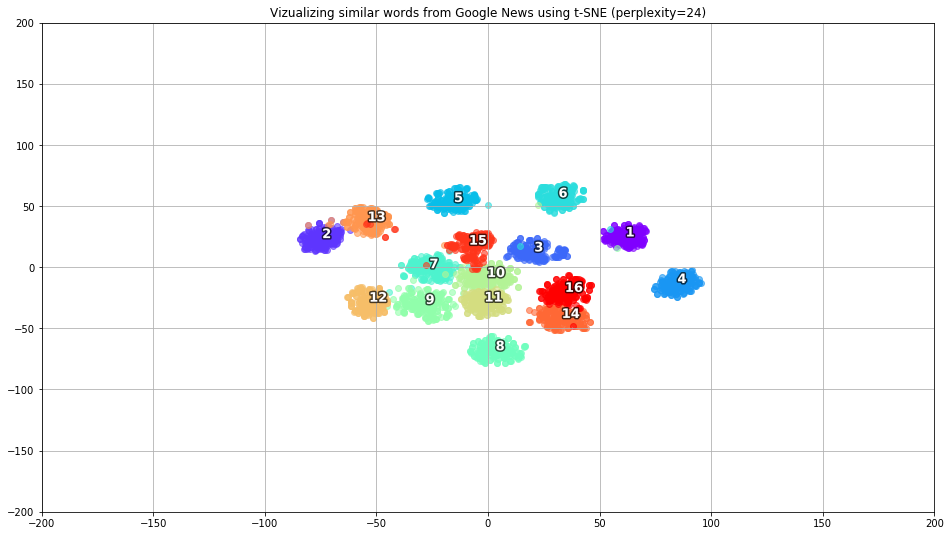

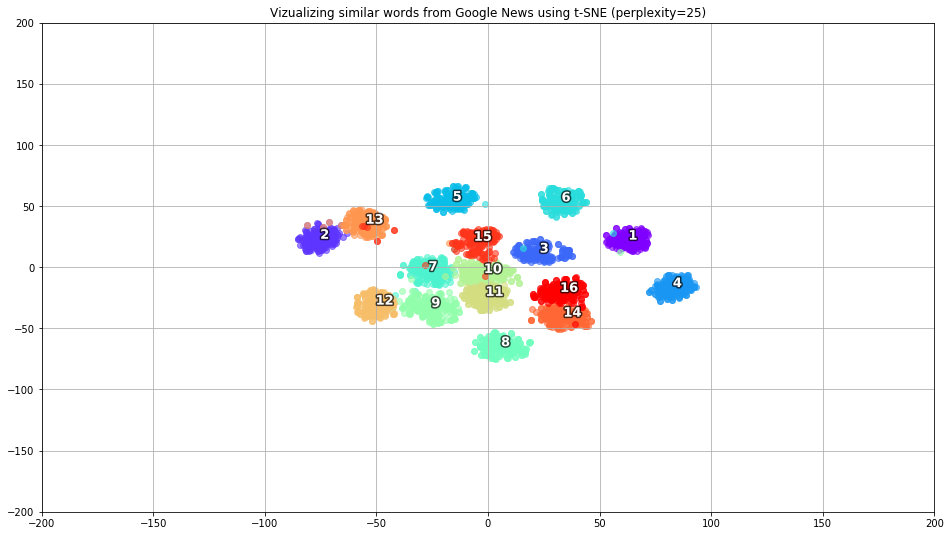

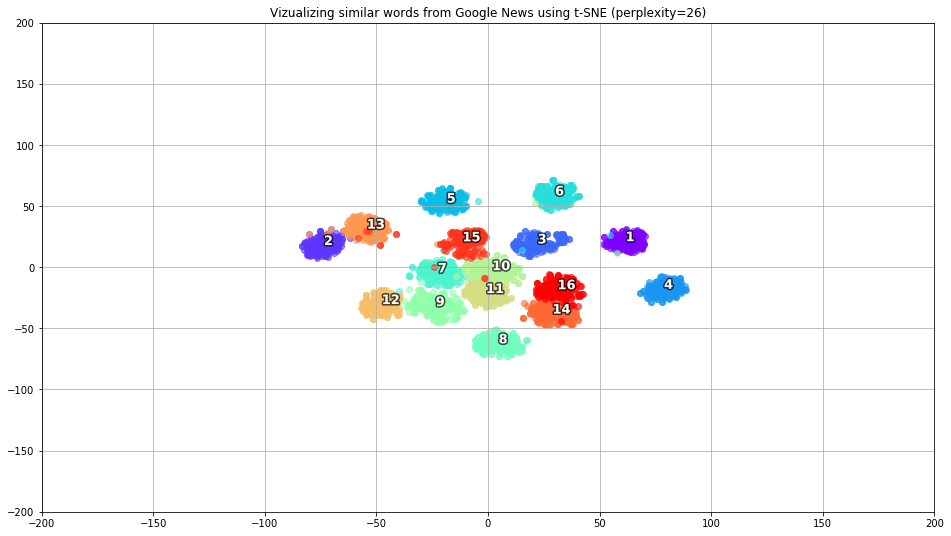

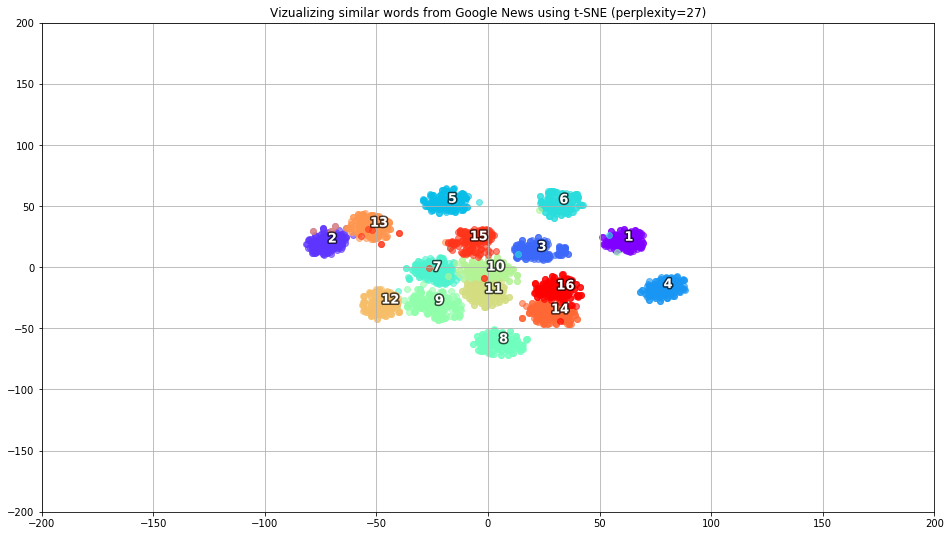

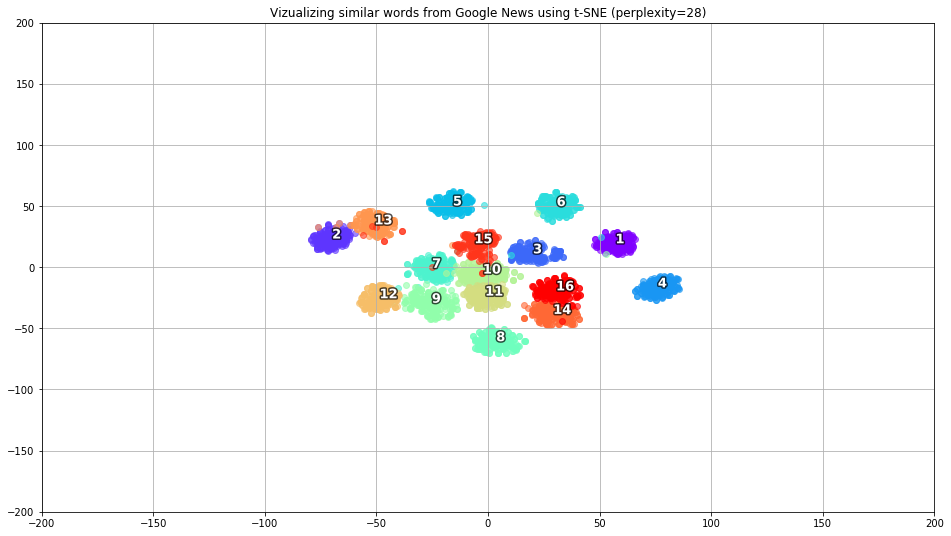

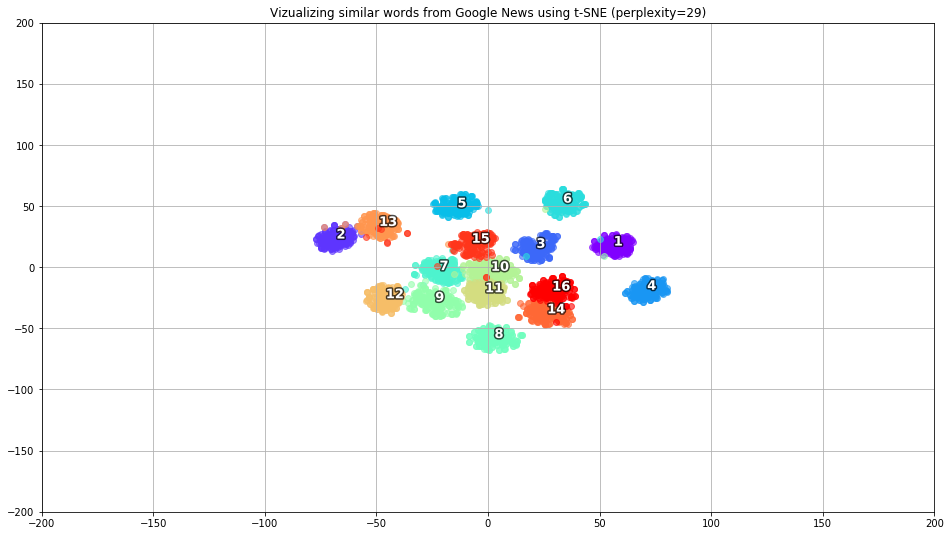

In [ ]:
import matplotlib.patheffects as PathEffects
import tempfile
import imageio
import shutil

def tsne_plot_similar_words_png(title, embedding_clusters, a, filename):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(embedding_clusters)))
    i = 1
    for embeddings, color in zip(embedding_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a)
        plt.text(x.mean(), y.mean(), str(i), color='white', weight='bold', fontsize=13, path_effects=[PathEffects.withStroke(linewidth=3,
                                                                          foreground="black", alpha=0.7)])
        i += 1
    plt.title(title)
    plt.grid(True)
    plt.xlim(-200, 200)
    plt.ylim(-200, 200)
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')


dirpath = tempfile.mkdtemp()
images = []
for i in range(1, 30):
    fname = os.path.join(dirpath, str(i) + '.png')
    tsne_model_en_2d_gif = TSNE(perplexity=i, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d_gif = np.array(tsne_model_en_2d_gif.fit_transform(embedding_clusters_gif.reshape(n * m, k))).reshape(n, m, 2)
    tsne_plot_similar_words_png('Vizualizing similar words from Google News using t-SNE (perplexity={})'.format(i), embeddings_en_2d_gif, 0.6, fname)
    images.append(imageio.imread(fname))
imageio.mimsave("2d1.gif", images, duration = 0.5)
shutil.rmtree(dirpath)

In [ ]:
imageio.mimsave("2d55.gif", images, duration = 0.5)

In [ ]:
from IPython.display import Image
Image(filename="2d1.gif")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os


def tsne_plot_3d_gif(title, label, embeddings, filename, a):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a)

    plt.title(title)

    red_patch = mpatches.Patch(color=colors[0], label=label)
    plt.legend(handles=[red_patch], loc=4)

    dirpath = tempfile.mkdtemp()
    images = []
    for angle in range(0, 360, 5):
        ax.view_init(30, angle)
        fname = os.path.join(dirpath, str(angle) + '.png')
        plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
        images.append(imageio.imread(fname))
    imageio.mimsave('3d.gif', images)
    shutil.rmtree(dirpath)


tsne_plot_3d_gif('Visualizing Word Embeddings using t-SNE', 'War and Peace\nby Leo Tolstoy',
                                  embeddings_wp_3d, '3d.gif', 0.1)

In [ ]:
from IPython.display import Image
Image(filename="3d.gif")